# spotMAX as a Python package

Here we show a simple example where we detect and quantify spots in synthetic data. 

While default parameters work with this simple image, we **highly recommend** reading the documentation in order to learn how to change the parameters. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import spotmax as sm

## Generate synthetic data

In [2]:
spots_radii = np.array([4, 6, 6])

spots_img, spots_gt_mask, spots_coords = sm.data.synthetic_spots(
    num_spots=20,
    shape=(25, 256, 256), 
    spots_radii=spots_radii, 
    noise_scale=0.05,
    noise_shape=0.03, 
    rng_seed=11
)
spots_img.shape

(25, 256, 256)

## Visualize max z-projection

Text(0.5, 1.0, 'Spots mask MAX z-projection')

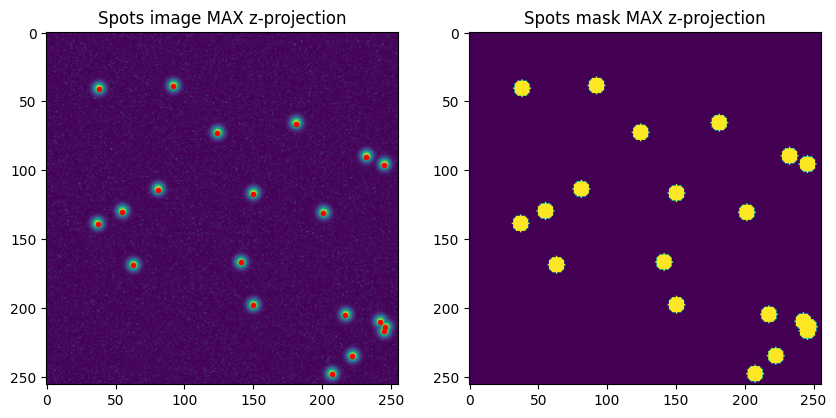

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(spots_img.max(axis=0))
ax[0].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[0].set_title('Spots image MAX z-projection')

ax[1].imshow(spots_gt_mask.max(axis=0))
# ax[1].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[1].set_title('Spots mask MAX z-projection')

## Segment spots
**Objective**: generate the same as ``spots_mask`` \
**Method**: try all thresholding methods and choose the best one (visually)

In [4]:
result = sm.pipe.spots_semantic_segmentation(
    spots_img, do_try_all_thresholds=True, do_sharpen=True
)

### Visualize max-projections of the result

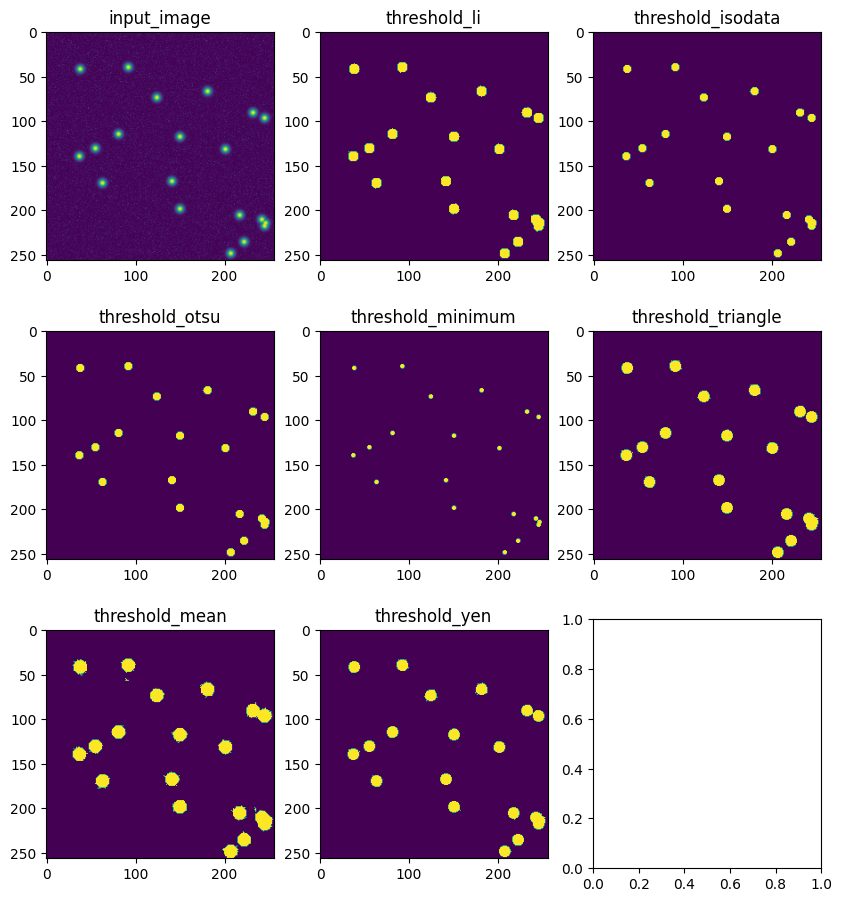

In [5]:
ncols = 3
nrows = len(result) // 3
nrows = nrows + 1 if len(result) % 3 else nrows
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 11))
ax = ax.flatten()
for a, (method, mask) in enumerate(result.items()):
    ax[a].imshow(mask.max(axis=0))
    ax[a].set_title(method)

## Detect the spots

**Objective**: detect center of the spots \
**Method**: Peak detection starting from ``threshold_otsu`` masks

By inspecting all the thresholding methods, we see that both ``threshold_otsu`` and ``threshold_isodata`` provide the best result. Therefore we continue with ``threshold_otsu``. 

In [6]:
spots_pred_mask = result['threshold_otsu']
spots_detect_img = result['input_image']
spots_zyx_radii_pxl = spots_radii

df_spots_coords, _ = sm.pipe.spot_detection(
    spots_detect_img, 
    spots_segmantic_segm=spots_pred_mask, 
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    return_df=True
)
print(f'Number of spots detected = {len(df_spots_coords)}')
df_spots_coords.head(10)

Number of spots detected = 20


z    y    x  z_local  y_local  x_local
Cell_ID spot_id                                         
1       1        20  205  217       20      205      217
        2        12  214  246       12      214      246
        3         6  217  245        6      217      245
        4         6   96  245        6       96      245
        5        13  117  150       13      117      150
        6        14  167  141       14      167      141
        7        16  248  207       16      248      207
        8        20  210  242       20      210      242
        9        17   41   38       17       41       38
        10        6   39   92        6       39       92

### Visualize spot detection

Text(0.5, 1.0, 'Spots mask MAX z-projection')

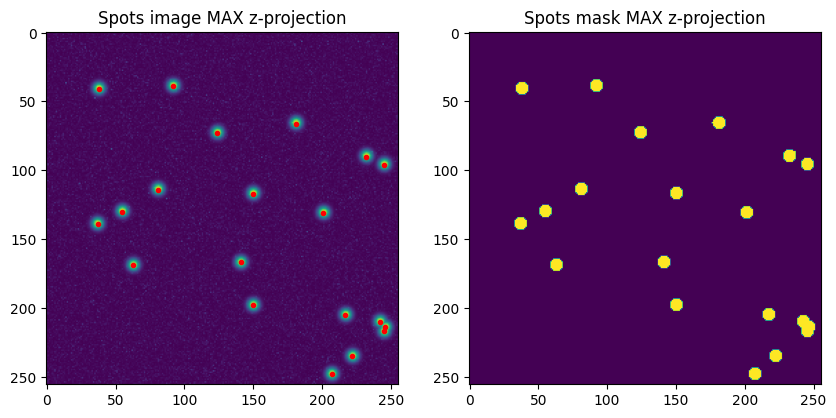

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(spots_detect_img.max(axis=0))
ax[0].plot(df_spots_coords['x'], df_spots_coords['y'], 'r.')
ax[0].set_title('Spots image MAX z-projection')

ax[1].imshow(spots_pred_mask.max(axis=0))
# ax[1].plot(spots_coords[:,2], spots_coords[:,1], 'r.')
ax[1].set_title('Spots mask MAX z-projection')

## Quantify the spots

For info about the calculated features see [here](https://spotmax.readthedocs.io//en/latest/features/single_spot_features_description.html)

In [8]:
keys, dfs_spots_det, dfs_spots_gop = sm.pipe.spots_calc_features_and_filter(
    spots_img, spots_zyx_radii_pxl, df_spots_coords, 
    sharp_spots_image=spots_detect_img, 
    optimise_for_high_spot_density=True, 
    show_progress=False, 
    verbose=False
)
columns = [
    'z', 'y', 'x', 'spot_center_raw_intensity', 
    'spot_vs_backgr_effect_size_glass'
]
df_spots = pd.concat(dfs_spots_gop, keys=keys, names=['frame_i', 'Cell_ID']).loc[0]
df_spots[columns].head(10)

z    y    x  spot_center_raw_intensity  spot_vs_backgr_effect_size_glass
Cell_ID spot_id                                                                           
1       1        20  205  217                   1.000000                         21.157650
        2        12  214  246                   0.998850                         18.263549
        3         6  217  245                   0.998800                         20.461023
        4         6   96  245                   0.995720                         20.267814
        5        13  117  150                   0.994681                         17.196437
        6        14  167  141                   0.993988                         17.691596
        7        16  248  207                   0.992724                         16.587077
        8        20  210  242                   0.992536                         21.162954
        9        17   41   38                   0.992487                         17.156366
        10        6   39   92                   0.992478                         20.322701

### Quantify spots with spotFIT

**Objective**: fit 3D gaussian functions to spots

In [9]:
spotfit_kernel = sm.core.SpotFIT()
df_spotfit, _ = sm.pipe.spotfit(
    spotfit_kernel, spots_img, df_spots, 
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    return_df=True, 
    verbose=False,
    show_progress=False
)
columns = [
    'z', 'y', 'x', 'z_fit', 'y_fit', 'x_fit', 
    'sigma_z_fit', 'sigma_y_fit', 'sigma_x_fit', 
    'total_integral_fit', 'RMSE_fit'
]
df_spotfit[columns].head(10)

z    y    x    z_fit     y_fit     x_fit  sigma_z_fit  sigma_y_fit  sigma_x_fit  total_integral_fit  RMSE_fit
frame_i Cell_ID spot_id                                                                                                                
0       1       1        20  205  217  19.9976  204.9943  217.0048     2.009087     3.006608     3.001068          243.385951  0.292070
                2        12  214  246  11.9985  213.9948  245.9874     2.033747     2.965535     2.957867          247.014199  0.228471
                3         6  217  245   6.0037  217.0009  244.9939     2.001133     2.999960     2.999580          243.009454  0.007023
                4         6   96  245   5.9996   96.0000  245.0006     2.001893     3.004962     3.001992          242.902366  0.285728
                5        13  117  150  13.0030  117.0025  149.9960     1.994104     2.988526     2.992276          242.203777  0.284580
                6        14  167  141  13.9956  166.9971  140.9993     1.998723     3.000872     2.999381          242.974410  0.286049
                7        16  248  207  15.9989  247.9965  206.9976     1.999336     3.003055     2.999241          242.688346  0.285497
                8        20  210  242  20.1113  209.9000  241.9000     1.811587     2.802161     2.801362          213.462654  0.223526
                9        17   41   38  17.0027   40.9951   38.0014     2.002398     2.994207     2.997931          242.650617  0.285579
                10        6   39   92   6.0011   38.9958   92.0010     1.997963     3.003173     2.996783          243.051144  0.285313

### Visualize spotFIT results

Here we visualize max z-projections of the image generated by spotFIT

Text(0.5, 1.0, 'SpotFIT labels')

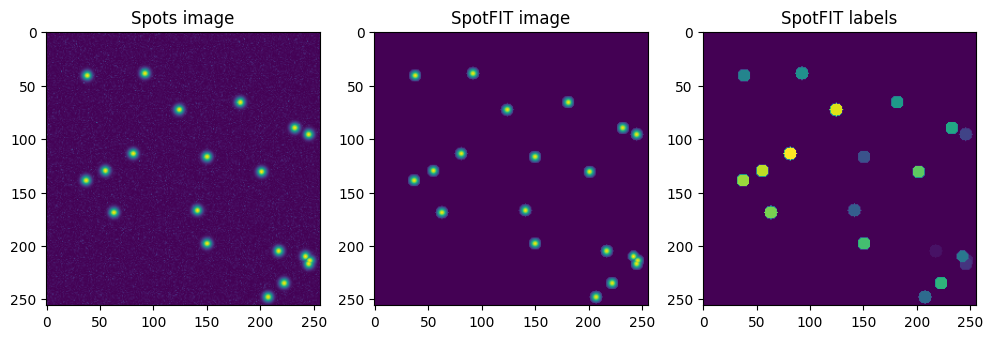

In [11]:
spotfit_img, spotfit_mask, spotfit_labels = (
    sm.utils.get_spotfit_image(df_spotfit.loc[0], spots_img.shape)
)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(spots_img.max(axis=0))
ax[0].set_title('Spots image')

ax[1].imshow(spotfit_img.max(axis=0))
ax[1].set_title('SpotFIT image')

ax[2].imshow(spotfit_labels.max(axis=0))
ax[2].set_title('SpotFIT labels')